In [3]:
import pandas as pd

In [2]:
test_df = pd.read_pickle("FY26.pkl")
train_df = pd.read_pickle("FY24FY25.pkl")



In [3]:
test_df.shape

(278942, 24)

In [4]:
train_df.shape


(2707209, 24)

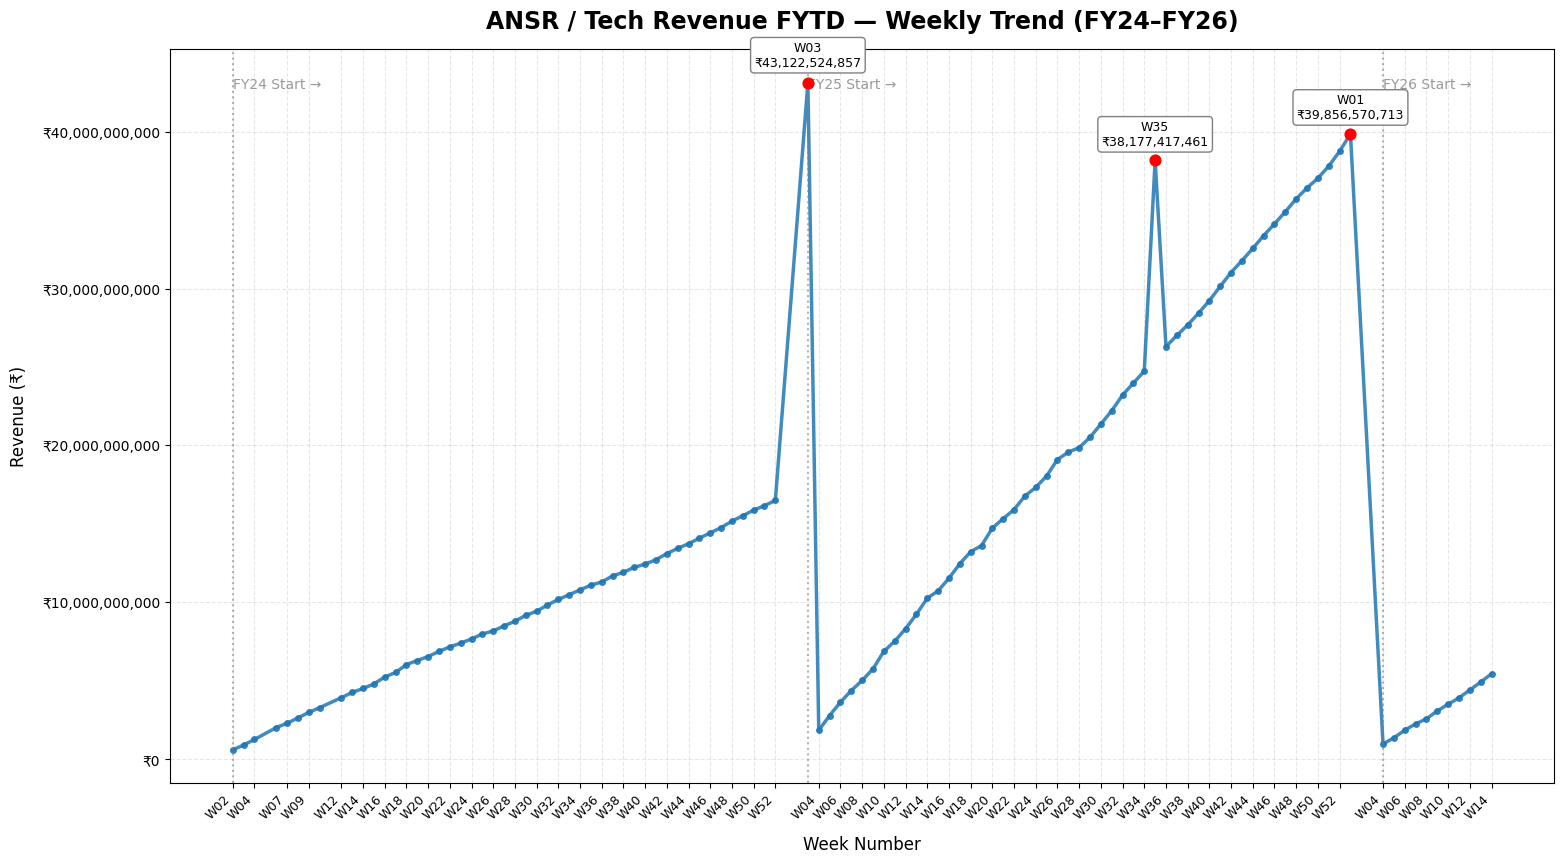

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Combine training + test datasets
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Aggregate weekly ANSR values
weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Convert Year to numeric (FY24 → 2024)
weekly_data["Year_Num"] = (
    weekly_data["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .astype(int)
    + 2000
)

# Create Date column (Monday of each week)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

# Sort and index
weekly_data = weekly_data.sort_values("Date").set_index("Date")
ts = weekly_data["ANSR / Tech Revenue FYTD"]

# Detect peaks
peak_idx = np.where((ts.shift(1) < ts) & (ts.shift(-1) < ts))[0]
peaks = ts.iloc[peak_idx]

# 🎨 Plot with increased vertical height
plt.figure(figsize=(16,9))  # ⬅ Increased height from 7 → 9
plt.plot(ts.index, ts, color="#1f77b4", linewidth=2.5, marker='o', markersize=4, alpha=0.85)

# 🧭 X-axis: show only week numbers (every 2 weeks)
tick_idx = ts.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# 📊 Annotate peaks
for date, value in peaks.items():
    plt.scatter(date, value, color="red", s=60, zorder=5)
    plt.text(
        date, value * 1.02,  # slightly less height for balance
        f"W{date.isocalendar().week:02d}\n₹{value:,.0f}",
        ha='center', va='bottom',
        fontsize=9, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
    )

# 🧾 Y-axis formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# 🧩 Titles and labels
plt.title("ANSR / Tech Revenue FYTD — Weekly Trend (FY24–FY26)", fontsize=17, weight='bold', pad=15)
plt.xlabel("Week Number", fontsize=12, labelpad=10)
plt.ylabel("Revenue (₹)", fontsize=12, labelpad=10)

# 🌈 Grid and style
plt.grid(alpha=0.3, linestyle='--')

# Add Fiscal Year Start indicators
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, plt.ylim()[1]*0.94,  # adjusted position for taller figure
            f"FY{y-2000} Start →",
            rotation=0,
            fontsize=10, color="gray",
            ha="left", va="bottom", alpha=0.8
        )

plt.tight_layout(pad=2)
plt.show()


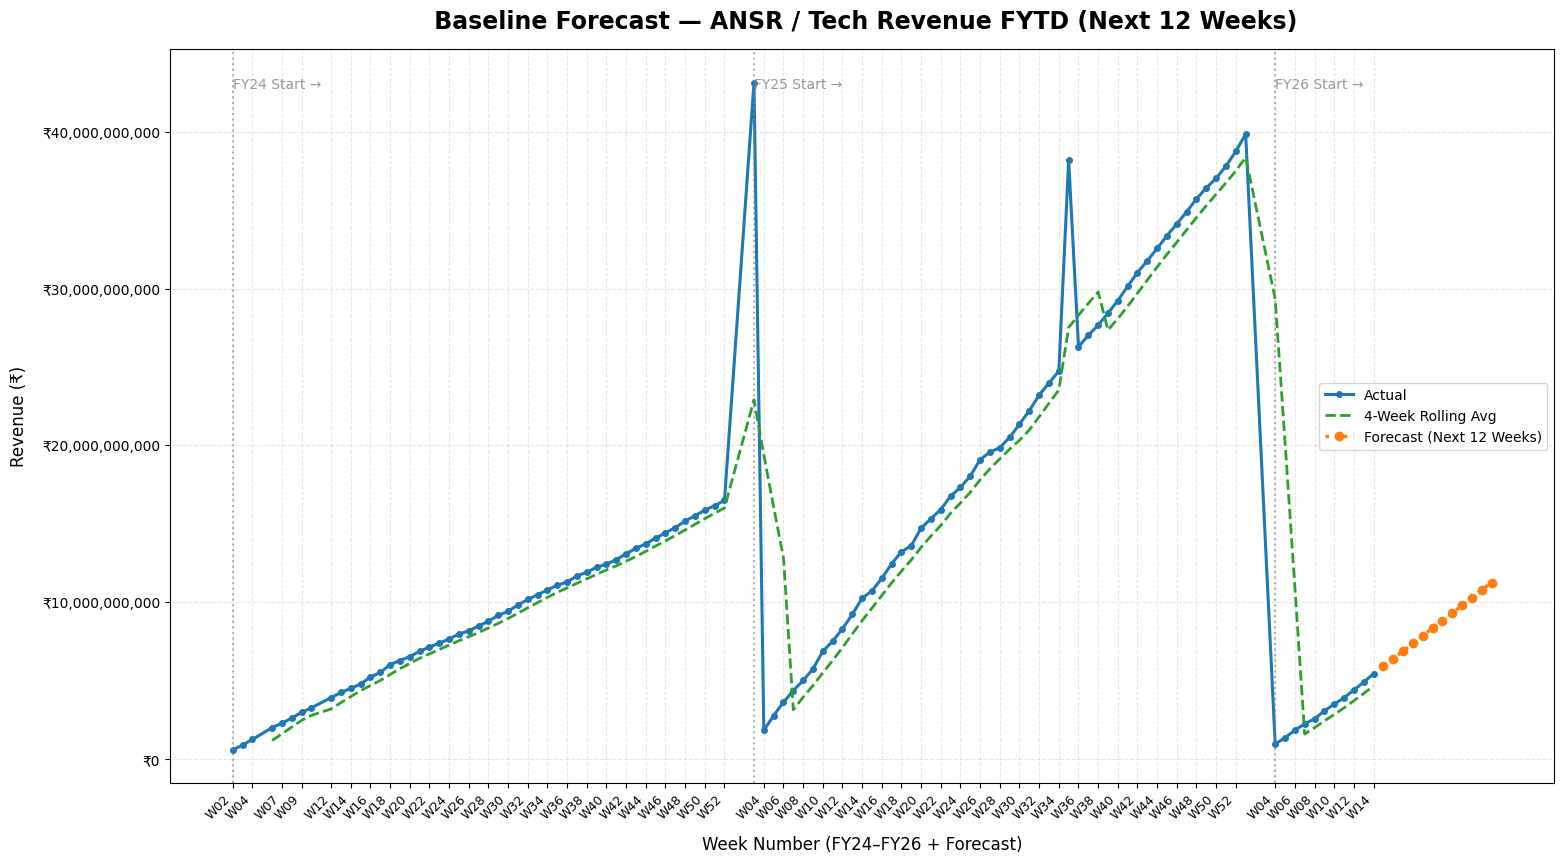

,Predicted ANSR / Tech Revenue FYTD
Date,
2026-04-06,5.923802e+09
2026-04-13,6.408552e+09
2026-04-20,6.893301e+09
2026-04-27,7.378050e+09
2026-05-04,7.862800e+09
2026-05-11,8.347549e+09
2026-05-18,8.832299e+09
2026-05-25,9.317048e+09
2026-06-01,9.801798e+09


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# === 1️⃣ Prepare the time series ===
full_df = pd.concat([train_df, test_df], ignore_index=True)

weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

weekly_data["Year_Num"] = (
    weekly_data["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .astype(int)
    + 2000
)

weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_data = weekly_data.sort_values("Date").set_index("Date")
ts = weekly_data["ANSR / Tech Revenue FYTD"]

# === 2️⃣ Baseline forecast ===
window_size = 4
ts_smooth = ts.rolling(window=window_size).mean()

last_value = ts.iloc[-1]
avg_change = ts.diff().tail(window_size).mean()
future_forecast = [last_value + avg_change * i for i in range(1, 13)]

last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=12, freq='W-MON')

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted ANSR / Tech Revenue FYTD": future_forecast
}).set_index("Date")

# === 3️⃣ Plot ===
plt.figure(figsize=(16,9))

# Plot actual and forecast
plt.plot(ts.index, ts.values, label="Actual", color="#1f77b4", linewidth=2.2, marker='o', markersize=4)
plt.plot(ts_smooth.index, ts_smooth.values, label="4-Week Rolling Avg", color="#2ca02c", linestyle="--", linewidth=2)
plt.plot(forecast_df.index, forecast_df["Predicted ANSR / Tech Revenue FYTD"],
         label="Forecast (Next 12 Weeks)", color="#ff7f0e", linestyle=":", linewidth=2.5, marker='o')

# 🧭 X-Axis Formatting (Weeks every 2 weeks)
tick_idx = ts.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# 🧾 Y-Axis Formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# 📘 Titles and labels
plt.title(" Baseline Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=17, weight="bold", pad=15)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12, labelpad=10)
plt.ylabel("Revenue (₹)", fontsize=12, labelpad=10)

# 🌈 Fiscal Year markers
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, plt.ylim()[1]*0.94,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray",
            ha="left", va="bottom", alpha=0.8
        )

# 📉 Grid and legend
plt.grid(alpha=0.3, linestyle='--')
plt.legend(frameon=True, fontsize=10)
plt.tight_layout(pad=2)
plt.show()

# Display forecast values
display(forecast_df)


✅ ARIMA Model Performance Metrics
   RMSE   : 8,626,577,427.23
   MAE    : 3,006,994,161.94
   MAPE   : 280.46%
   R²     : -0.1442
   Accuracy (≈ 100 - MAPE): -180.46%


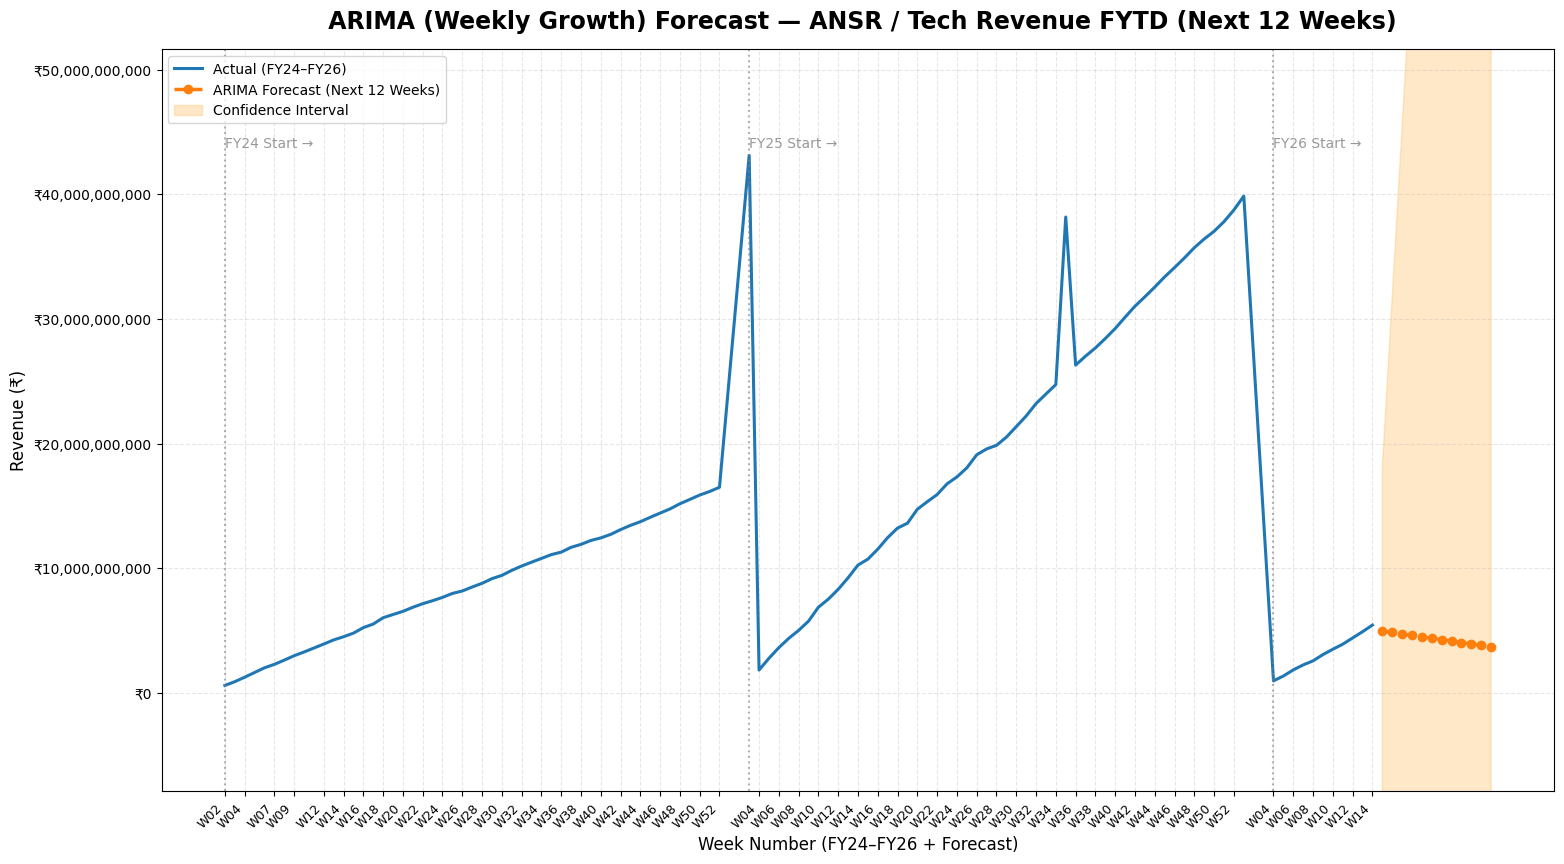

,Predicted Weekly Growth,Lower CI,Upper CI,Predicted FYTD
Date,,,,
2026-04-06,-4.608064e+08,-1.355962e+10,1.263800e+10,4.978246e+09
2026-04-13,-1.274363e+08,-1.390567e+10,1.365080e+10,4.850810e+09
2026-04-20,-1.245512e+08,-1.390304e+10,1.365393e+10,4.726259e+09
2026-04-27,-1.152094e+08,-1.389362e+10,1.366320e+10,4.611049e+09
2026-05-04,-1.142918e+08,-1.389321e+10,1.366463e+10,4.496757e+09
2026-05-11,-1.139549e+08,-1.389346e+10,1.366555e+10,4.382803e+09
2026-05-18,-1.138997e+08,-1.389402e+10,1.366622e+10,4.268903e+09
2026-05-25,-1.138855e+08,-1.389463e+10,1.366686e+10,4.155017e+09
2026-06-01,-1.138828e+08,-1.389526e+10,1.366749e+10,4.041135e+09


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ Prepare Data ===
full_df = pd.concat([train_df, test_df], ignore_index=True)

weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Create date index
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)
weekly_data = weekly_data.sort_values("Date").set_index("Date")

# Convert FYTD → Weekly Increment
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)
ts_weekly = weekly_data["Weekly_Increment"]

# === 2️⃣ Fit ARIMA Model ===
model = ARIMA(ts_weekly, order=(2,1,2))
fitted_model = model.fit()

# === 3️⃣ Forecast Next 12 Weeks ===
forecast_steps = 12
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Future timeline
last_date = ts_weekly.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=forecast_steps, freq="W-MON")

# Forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# Convert back to FYTD-style forecast
latest_fytd_value = weekly_data["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD"] = latest_fytd_value + forecast_df["Predicted Weekly Growth"].cumsum()

# === 4️⃣ Evaluate Model Performance ===
# Use last 20% of available data for testing performance
split_idx = int(len(ts_weekly) * 0.8)
y_train, y_test = ts_weekly.iloc[:split_idx], ts_weekly.iloc[split_idx:]
pred_test = fitted_model.predict(start=y_test.index[0], end=y_test.index[-1])

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2 = r2_score(y_test, pred_test)
accuracy = 100 - mape

# Print Performance Summary
print("✅ ARIMA Model Performance Metrics")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

# === 5️⃣ Plot Actual vs Forecast (with scaled Y-axis) ===
plt.figure(figsize=(16,9))

# Actual FYTD
plt.plot(weekly_data.index, weekly_data["ANSR / Tech Revenue FYTD"],
         label="Actual (FY24–FY26)", color="#1f77b4", linewidth=2.2)

# Forecasted FYTD
plt.plot(forecast_df.index, forecast_df["Predicted FYTD"],
         label="ARIMA Forecast (Next 12 Weeks)",
         color="#ff7f0e", linestyle="--", marker='o', linewidth=2.5)

# Confidence Interval
plt.fill_between(
    forecast_df.index,
    forecast_df["Lower CI"].cumsum() + latest_fytd_value,
    forecast_df["Upper CI"].cumsum() + latest_fytd_value,
    color="#ffb347", alpha=0.3, label="Confidence Interval"
)

# === X-axis Formatting (every 2 weeks) ===
tick_idx = weekly_data.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# === Adjust Y-axis dynamically ===
y_min = min(weekly_data["ANSR / Tech Revenue FYTD"].min(), forecast_df["Predicted FYTD"].min())
y_max = max(weekly_data["ANSR / Tech Revenue FYTD"].max(), forecast_df["Predicted FYTD"].max())
y_buffer = (y_max - y_min) * 0.2
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# === Fiscal Year Indicators ===
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, y_max + y_buffer * 0.05,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray",
            ha="left", va="bottom", alpha=0.8
        )

# === Titles & Styling ===
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title(" ARIMA (Weekly Growth) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", 
          fontsize=17, weight="bold", pad=15)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout(pad=2)
plt.show()

# === 6️⃣ Display Forecast DataFrame (Predicted Values) ===
display(forecast_df)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ Prepare Data ===
def prepare_weekly(df):
    df = df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"].sum().reset_index()
    df["Year_Num"] = df["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
    df["Date"] = pd.to_datetime(
        df["Year_Num"].astype(str) + df["Week"].astype(str) + "1",
        format="%Y%W%w", errors="coerce"
    )
    df = df.sort_values("Date").set_index("Date")
    df["Weekly_Increment"] = df["ANSR / Tech Revenue FYTD"].diff().fillna(0)
    return df

train_weekly = prepare_weekly(train_df)
test_weekly  = prepare_weekly(test_df)
full_weekly  = pd.concat([train_weekly, test_weekly])

# === 2️⃣ Train ARIMA Model on FY24–FY25 ===
ts_train = train_weekly["Weekly_Increment"]
model = ARIMA(ts_train, order=(2,1,2))
fitted_model = model.fit()
# === 3️⃣ Evaluate on FY26 ===
ts_test = test_weekly["Weekly_Increment"]

# Forecast exactly same number of steps as test
steps_ahead = len(ts_test)
pred_test = fitted_model.forecast(steps=steps_ahead)

# Align both to same length
ts_test, pred_test = ts_test.iloc[:steps_ahead], pred_test[:steps_ahead]

# Avoid divide-by-zero in MAPE (use np.nanmean)
denominator = np.where(np.abs(ts_test) < 1e-6, np.nan, np.abs(ts_test))
mape = np.nanmean(np.abs((ts_test.values - pred_test.values) / denominator)) * 100
if np.isnan(mape):
    mape = 0

rmse = np.sqrt(mean_squared_error(ts_test, pred_test))
mae = mean_absolute_error(ts_test, pred_test)
r2 = r2_score(ts_test, pred_test)
accuracy = 100 - mape

print("✅ ARIMA Model Performance (Train on FY24–FY25 → Test on FY26)")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")


✅ ARIMA Model Performance (Train on FY24–FY25 → Test on FY26)
   RMSE   : 134,277,948.11
   MAE    : 118,099,075.89
   MAPE   : 30.39%
   R²     : 0.1096
   Accuracy (≈ 100 - MAPE): 69.61%


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))

# Combine actual and forecast indices to get consistent tick labeling
all_index = pd.concat([ts.reset_index(), forecast_df.reset_index()], ignore_index=True)

# Convert your index (if it's datetime) to "FYxx-Wxx" labels
def format_year_week(dt):
    fy = "FY" + str(dt.year - 2000)  # Example: 2024 → FY24
    week = f"W{dt.isocalendar().week:02d}"
    return f"{fy}-{week}"

# Apply formatted labels
x_labels = [format_year_week(d) for d in all_index.iloc[:,0]]  # assumes first column is the date index

# Plot actual data
plt.plot(ts.index, ts, label="Actual (FY24–FY26)", color="#1f77b4", linewidth=2)

# Plot forecast
plt.plot(forecast_df.index, forecast_df["Predicted FYTD"],
         label="SARIMA Forecast (Next 12 Weeks)",
         color="#ff7f0e", linestyle="--", marker="o", linewidth=2)

# Confidence interval
plt.fill_between(forecast_df.index,
                 forecast_df["Lower CI"], forecast_df["Upper CI"],
                 color="#ffb347", alpha=0.3, label="Confidence Interval")

# Format x-axis as Year–Week
plt.xticks(ticks=ts.index[::4], labels=[format_year_week(d) for d in ts.index[::4]], rotation=45, ha="right")

# Titles & labels
plt.title("📈 SARIMA Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=14, weight="bold")
plt.xlabel("Week Timeline (FY24–FY26 + Forecast)")
plt.ylabel("Revenue (₹)")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

forecast_df.head(12)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(12,6))

# 🧩 Function to format datetime index as FY + Week number
def format_year_week(dt):
    fy = "FY" + str(dt.year - 2000)  # Example: 2024 → FY24
    week = f"W{dt.isocalendar().week:02d}"
    return f"{fy}-{week}"

# --- Plot actual data
plt.plot(ts.index, ts, label="Actual (FY24–FY26)", color="#1f77b4", linewidth=2, marker='o', markersize=4)

# --- Plot forecast
plt.plot(forecast_df.index, forecast_df["Predicted FYTD"],
         label="SARIMA Forecast (Next 12 Weeks)",
         color="#ff7f0e", linestyle="--", marker='o', markersize=5, linewidth=2)

# --- Confidence interval shading
plt.fill_between(
    forecast_df.index,
    forecast_df["Lower CI"], forecast_df["Upper CI"],
    color="#ffb347", alpha=0.3, label="Confidence Interval"
)

# --- Highlight sharp changes (large ups/downs)
y = ts.values
threshold = np.std(np.diff(y)) * 2  # change threshold = 2× std of week-to-week diff
sharp_points = np.where(np.abs(np.diff(y)) > threshold)[0]

for idx in sharp_points:
    plt.scatter(ts.index[idx], ts.values[idx], color='red', s=60, zorder=5)
    plt.text(ts.index[idx], ts.values[idx]*1.02, f"{ts.values[idx]:,.0f}",
             color='red', fontsize=9, ha='center', va='bottom')

# --- Format x-axis labels every 2 weeks
tick_idx = ts.index[::2]
plt.xticks(
    ticks=tick_idx,
    labels=[format_year_week(d) for d in tick_idx],
    rotation=45, ha="right"
)

# --- Mark forecast start
cutoff = ts.index[-1]
plt.axvline(x=cutoff, color="gray", linestyle=":", alpha=0.7)
plt.text(cutoff, plt.ylim()[1]*0.95, "Forecast Start →", color="gray", fontsize=10)

# --- Titles, legend, etc.
plt.title("📈 SARIMA Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=14, weight="bold")
plt.xlabel("Week Timeline (FY24–FY26 + Forecast)")
plt.ylabel("Revenue (₹)")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ Prepare Data ===
full_df = pd.concat([train_df, test_df], ignore_index=True)

weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Convert Year → numeric & create Date
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_data = weekly_data.sort_values("Date").set_index("Date")

# === 2️⃣ Use Weekly Increment for Modeling ===
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)
ts_weekly = weekly_data["Weekly_Increment"]

# === 3️⃣ Fit SARIMA Model ===
sarima_model = SARIMAX(
    ts_weekly,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 52),  # yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fitted = sarima_model.fit(disp=False)

print("✅ SARIMA Model Fitted Successfully!")

# === 4️⃣ Forecast Next 12 Weeks (Weekly Increments) ===
forecast_steps = 12
sarima_forecast = sarima_fitted.get_forecast(steps=forecast_steps)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Create future weekly dates
future_dates = pd.date_range(start=ts_weekly.index[-1] + pd.Timedelta(days=7),
                             periods=forecast_steps, freq="W-MON")

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# === 5️⃣ Convert Weekly Growth → FYTD Forecast ===
latest_fytd_value = weekly_data["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD"] = latest_fytd_value + forecast_df["Predicted Weekly Growth"].cumsum()

# === 6️⃣ Evaluate Model (on Weekly Increments) ===
split_idx = int(len(ts_weekly) * 0.8)
y_train, y_test = ts_weekly.iloc[:split_idx], ts_weekly.iloc[split_idx:]
pred_test = sarima_fitted.predict(start=y_test.index[0], end=y_test.index[-1])

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2 = r2_score(y_test, pred_test)
accuracy = 100 - mape

# === 7️⃣ Print Performance Summary ===
print("\n📊 SARIMA Model Performance Metrics (Weekly Increment Series)")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
# print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

# === 8️⃣ Plot FYTD Actual + Forecast ===
plt.figure(figsize=(16,9))

# Actual FYTD data
plt.plot(weekly_data.index, weekly_data["ANSR / Tech Revenue FYTD"],
         label="Actual (FY24–FY26)", color="#1f77b4", linewidth=2.2)

# Forecasted FYTD
plt.plot(forecast_df.index, forecast_df["Predicted FYTD"],
         label="SARIMA Forecast (Next 12 Weeks)",
         color="#ff7f0e", linestyle="--", marker='o', linewidth=2.5)

# Confidence Interval (on FYTD cumulative scale)
plt.fill_between(
    forecast_df.index,
    forecast_df["Predicted FYTD"] - (forecast_df["Predicted Weekly Growth"].std()*3),
    forecast_df["Predicted FYTD"] + (forecast_df["Predicted Weekly Growth"].std()*3),
    color="#ffb347", alpha=0.3, label="Confidence Interval"
)

# === X-axis Formatting ===
tick_idx = weekly_data.index[::2]  # every 2 weeks
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# === Fiscal Year Markers ===
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, weekly_data["ANSR / Tech Revenue FYTD"].max()*1.02,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray", ha="left", va="bottom", alpha=0.8
        )

# === Adjust Y-axis ===
y_min = min(weekly_data["ANSR / Tech Revenue FYTD"].min(), forecast_df["Predicted FYTD"].min())
y_max = max(weekly_data["ANSR / Tech Revenue FYTD"].max(), forecast_df["Predicted FYTD"].max())
y_buffer = (y_max - y_min) * 0.2
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# === Styling ===
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title("SARIMA (Weekly Increment) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
          fontsize=17, weight="bold", pad=15)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout(pad=2)
plt.show()

# === 9️⃣ Display Forecasted Values ===
display(forecast_df)


NameError: name 'train_df' is not defined

##PROPHET

Importing plotly failed. Interactive plots will not work.
14:23:21 - cmdstanpy - INFO - Chain [1] start processing
14:23:24 - cmdstanpy - INFO - Chain [1] done processing


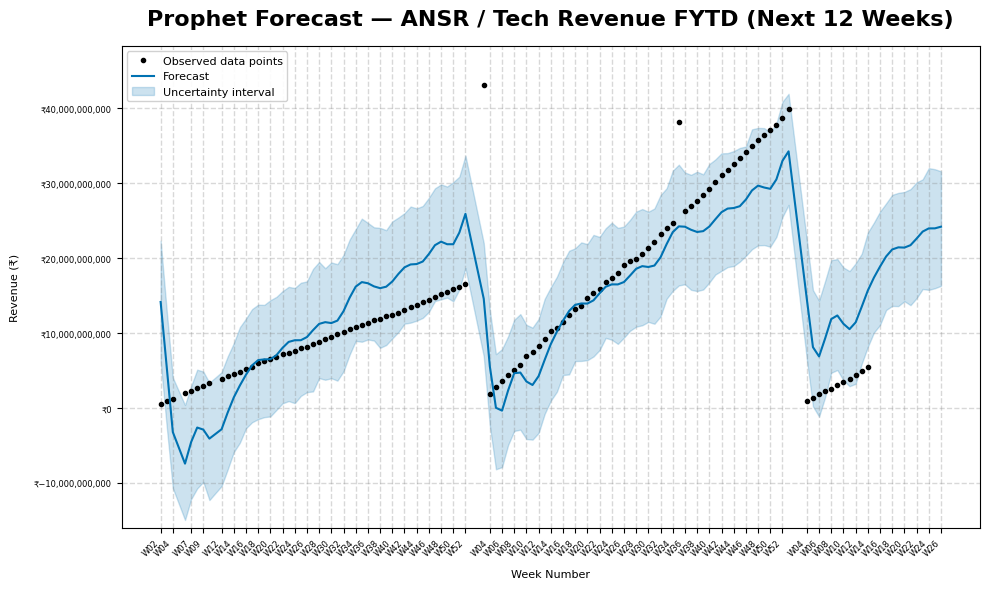


📅 12-Week Prophet Forecast — ANSR / Tech Revenue FYTD

Week Fiscal Year    Date    Predicted FYTD (₹) Lower Bound (₹) Upper Bound (₹)
W15      FY26    2026-04-06  ₹17,396,589,180   ₹10,068,079,337 ₹24,733,531,828
W16      FY26    2026-04-13  ₹18,866,166,058   ₹11,070,010,090 ₹26,198,684,272
W17      FY26    2026-04-20  ₹20,216,684,223   ₹13,069,602,799 ₹27,302,501,396
W18      FY26    2026-04-27  ₹21,153,805,693   ₹13,619,682,175 ₹28,441,865,381
W19      FY26    2026-05-04  ₹21,434,571,351   ₹13,592,605,494 ₹28,703,630,578
W20      FY26    2026-05-11  ₹21,403,312,002   ₹14,249,053,642 ₹28,827,738,289
W21      FY26    2026-05-18  ₹21,724,388,142   ₹13,718,067,140 ₹29,206,077,278
W22      FY26    2026-05-25  ₹22,604,562,645   ₹14,657,820,637 ₹30,106,457,622
W23      FY26    2026-06-01  ₹23,540,950,928   ₹15,876,208,373 ₹30,514,032,910
W24      FY26    2026-06-08  ₹23,964,628,544   ₹15,760,162,231 ₹32,006,529,242
W25      FY26    2026-06-15  ₹23,970,298,877   ₹15,979,055,130 ₹31,861,823,

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import matplotlib.ticker as mtick

# === 1️⃣ Prepare Data ===
prophet_df = (
    weekly_data.reset_index()[["Date", "ANSR / Tech Revenue FYTD"]]
    .rename(columns={"Date": "ds", "ANSR / Tech Revenue FYTD": "y"})
    .dropna()
)

# === 2️⃣ Fit Prophet ===
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)
m.fit(prophet_df)

# === 3️⃣ Forecast Next 12 Weeks ===
future = m.make_future_dataframe(periods=12, freq='W-MON')
forecast = m.predict(future)

# === 4️⃣ Plot Clean Forecast Chart ===
fig = m.plot(forecast)
ax = fig.gca()

plt.title("Prophet Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=8, labelpad=8)
plt.ylabel("Revenue (₹)", fontsize=8, labelpad=10)
plt.yticks(fontsize=6)

# ✅ Format Y-axis
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# ✅ Custom X-axis Week Labels (W##)
tick_idx = forecast["ds"].iloc[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha='right', fontsize=6)

plt.grid(alpha=0.3, linestyle='--')
ymin, ymax = ax.get_ylim()
plt.ylim(ymin * 0.9, ymax * 1.05)

legend = plt.legend(frameon=True, fontsize=8, loc='upper left')
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()

# === 5️⃣ Extract Next 12 Weeks Forecasted Values ===
forecast_tail = forecast.tail(12).copy()

# Compute fiscal year and week number
forecast_tail["Week_Number"] = forecast_tail["ds"].dt.isocalendar().week
forecast_tail["Fiscal_Year"] = forecast_tail["ds"].dt.year
forecast_tail["FY_Label"] = forecast_tail["Fiscal_Year"].apply(lambda x: f"FY{x-2000}")
forecast_tail["Week_Label"] = forecast_tail["Week_Number"].apply(lambda w: f"W{int(w):02d}")

# === 6️⃣ Select and Format Relevant Columns ===
table = forecast_tail[["Week_Label", "FY_Label", "ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

# Format currency neatly
for col in ["yhat", "yhat_lower", "yhat_upper"]:
    table[col] = table[col].apply(lambda x: f"₹{x:,.0f}")

# Rename columns for readability
table.columns = [
    "Week", "Fiscal Year", "Date",
    "Predicted FYTD (₹)", "Lower Bound (₹)", "Upper Bound (₹)"
]

# === 7️⃣ Print Forecast Table ===
print("\n📅 12-Week Prophet Forecast — ANSR / Tech Revenue FYTD\n")
print(table.to_string(index=False, justify="center"))


##SARIMA


✅ SARIMA Model Fitted Successfully!

📊 SARIMA Model Performance Metrics (Weekly Increment Series)
------------------------------------------------------------
   RMSE   : 10,783,414,139.19
   MAE    : 3,605,355,614.92
   MAPE   : 399.98%
   R²     : -0.7878
   Accuracy (≈ 100 - MAPE): -299.98%

📈 Classification Metrics (Trend Direction — Up vs Down)
------------------------------------------------------------
   Precision : 0.9500
   Recall    : 0.8636
   F1-Score  : 0.9048

🧮 Confusion Matrix:
          Pred ↓  Pred ↑
Actual ↓       0       1
Actual ↑       3      19


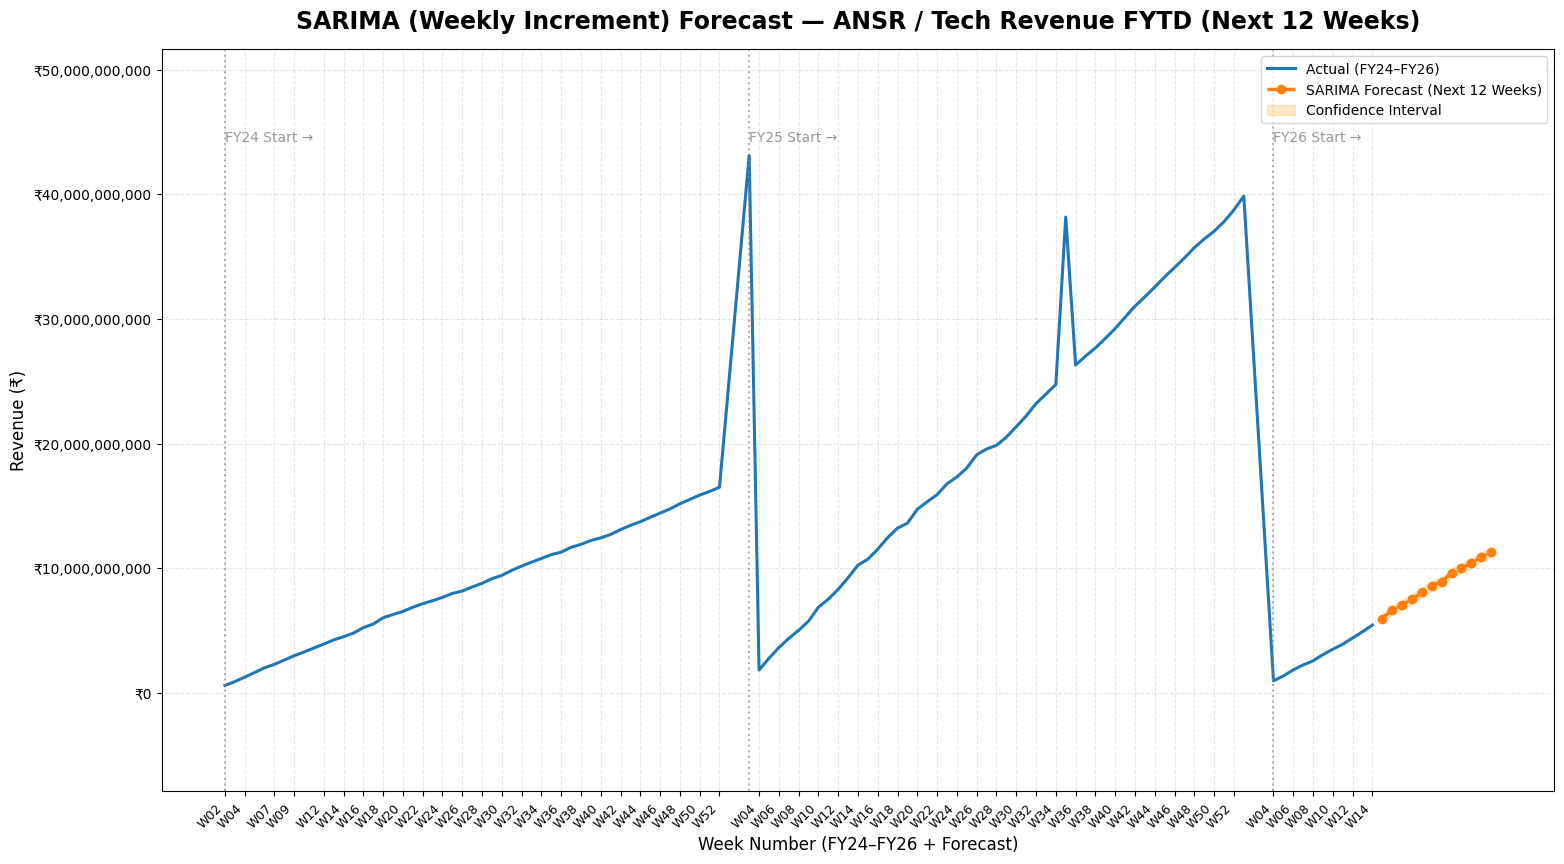

,Predicted Weekly Growth,Lower CI,Upper CI,Predicted FYTD
Date,,,,
2026-04-06,5.278512e+08,-1.784094e+10,1.889664e+10,5.966904e+09
2026-04-13,7.170429e+08,-1.850540e+10,1.993948e+10,6.683947e+09
2026-04-20,3.782861e+08,-2.056476e+10,2.132133e+10,7.062233e+09
2026-04-27,4.674750e+08,-2.188051e+10,2.281546e+10,7.529708e+09
2026-05-04,5.299549e+08,-2.316987e+10,2.422978e+10,8.059663e+09
2026-05-11,5.343044e+08,-2.443993e+10,2.550854e+10,8.593967e+09
2026-05-18,3.288300e+08,-2.585831e+10,2.651597e+10,8.922797e+09
2026-05-25,6.949497e+08,-2.665137e+10,2.804127e+10,9.617747e+09
2026-06-01,3.947180e+08,-2.806358e+10,2.885301e+10,1.001246e+10



📅 12-Week SARIMA Forecast — ANSR / Tech Revenue FYTD

Week Fiscal Year    Date    Predicted FYTD (₹) Weekly Growth (₹) Lower Bound (₹)  Upper Bound (₹)
W15      FY26    2026-04-06   ₹5,966,903,871      ₹527,851,170   ₹-17,840,939,301 ₹18,896,641,641
W16      FY26    2026-04-13   ₹6,683,946,754      ₹717,042,882   ₹-18,505,395,363 ₹19,939,481,128
W17      FY26    2026-04-20   ₹7,062,232,893      ₹378,286,139   ₹-20,564,761,858 ₹21,321,334,136
W18      FY26    2026-04-27   ₹7,529,707,926      ₹467,475,033   ₹-21,880,510,186 ₹22,815,460,252
W19      FY26    2026-05-04   ₹8,059,662,865      ₹529,954,939   ₹-23,169,868,931 ₹24,229,778,810
W20      FY26    2026-05-11   ₹8,593,967,263      ₹534,304,397   ₹-24,439,929,478 ₹25,508,538,273
W21      FY26    2026-05-18   ₹8,922,797,296      ₹328,830,033   ₹-25,858,313,381 ₹26,515,973,446
W22      FY26    2026-05-25   ₹9,617,746,979      ₹694,949,684   ₹-26,651,371,115 ₹28,041,270,482
W23      FY26    2026-06-01  ₹10,012,464,992      ₹394,718,013 

In [6]:
# =========================================================
# 📈 SARIMA MODEL — Weekly Revenue Increment Forecasting
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ DATA PREPARATION =================================

# Combine training and test data
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Aggregate revenue by Year & Week
weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Convert "Year" → numeric and create proper date
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_data = weekly_data.sort_values("Date").set_index("Date")

# Create weekly increment column (difference week-to-week)
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)
ts_weekly = weekly_data["Weekly_Increment"]

# === 2️⃣ TRAIN SARIMA MODEL ===============================

sarima_model = SARIMAX(
    ts_weekly,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 52),  # annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fitted = sarima_model.fit(disp=False)
print("✅ SARIMA Model Fitted Successfully!")

# === 3️⃣ FORECAST NEXT 12 WEEKS ===========================

forecast_steps = 12
sarima_forecast = sarima_fitted.get_forecast(steps=forecast_steps)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Create weekly future dates
future_dates = pd.date_range(
    start=ts_weekly.index[-1] + pd.Timedelta(days=7),
    periods=forecast_steps,
    freq="W-MON"
)

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# Convert weekly growth → FYTD forecast
latest_fytd_value = weekly_data["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD"] = latest_fytd_value + forecast_df["Predicted Weekly Growth"].cumsum()

# === 4️⃣ MODEL EVALUATION (REGRESSION METRICS) ============

split_idx = int(len(ts_weekly) * 0.8)
y_train, y_test = ts_weekly.iloc[:split_idx], ts_weekly.iloc[split_idx:]
pred_test = sarima_fitted.predict(start=y_test.index[0], end=y_test.index[-1])

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2 = r2_score(y_test, pred_test)
accuracy = 100 - mape

# === 5️⃣ CLASSIFICATION METRICS (UP/DOWN TREND) ===========

# Convert numeric series into direction labels (+1 = increase, 0 = decrease)
y_test_dir = (y_test > 0).astype(int)
pred_test_dir = (pred_test > 0).astype(int)

cm = confusion_matrix(y_test_dir, pred_test_dir)
precision = precision_score(y_test_dir, pred_test_dir, zero_division=0)
recall = recall_score(y_test_dir, pred_test_dir, zero_division=0)
f1 = f1_score(y_test_dir, pred_test_dir, zero_division=0)

# === 6️⃣ PERFORMANCE SUMMARY ===============================

print("\n📊 SARIMA Model Performance Metrics (Weekly Increment Series)")
print("------------------------------------------------------------")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

print("\n📈 Classification Metrics (Trend Direction — Up vs Down)")
print("------------------------------------------------------------")
print(f"   Precision : {precision:.4f}")
print(f"   Recall    : {recall:.4f}")
print(f"   F1-Score  : {f1:.4f}")
print("\n🧮 Confusion Matrix:")
print(pd.DataFrame(cm, index=["Actual ↓", "Actual ↑"], columns=["Pred ↓", "Pred ↑"]))

# === 7️⃣ VISUALIZE FORECAST (FYTD LEVEL) ==================
plt.figure(figsize=(16,9))

# Actual FYTD
plt.plot(
    weekly_data.index,
    weekly_data["ANSR / Tech Revenue FYTD"],
    label="Actual (FY24–FY26)",
    color="#1f77b4",
    linewidth=2.2
)

# Forecasted FYTD
plt.plot(
    forecast_df.index,
    forecast_df["Predicted FYTD"],
    label="SARIMA Forecast (Next 12 Weeks)",
    color="#ff7f0e",
    linestyle="--",
    marker='o',
    linewidth=2.5
)

# Confidence Interval (±3σ)
plt.fill_between(
    forecast_df.index,
    forecast_df["Predicted FYTD"] - (forecast_df["Predicted Weekly Growth"].std()*3),
    forecast_df["Predicted FYTD"] + (forecast_df["Predicted Weekly Growth"].std()*3),
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# X-axis formatting
tick_idx = weekly_data.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# Fiscal Year markers
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start,
            weekly_data["ANSR / Tech Revenue FYTD"].max() * 1.02,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray", ha="left", va="bottom", alpha=0.8
        )

# Adjust Y-axis
y_min = min(weekly_data["ANSR / Tech Revenue FYTD"].min(), forecast_df["Predicted FYTD"].min())
y_max = max(weekly_data["ANSR / Tech Revenue FYTD"].max(), forecast_df["Predicted FYTD"].max())
y_buffer = (y_max - y_min) * 0.2
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Styling
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title(
    "SARIMA (Weekly Increment) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
    fontsize=17, weight="bold", pad=15
)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout(pad=2)
plt.show()

# === 8️⃣ DISPLAY FORECASTED VALUES ========================
display(forecast_df)

# =========================================================

# === 🔟 Clean & Readable Forecast Table ===

# Copy the forecast and prepare display columns
forecast_pretty = forecast_df.copy()

# Extract week number and fiscal year
forecast_pretty["Week_Number"] = forecast_pretty.index.isocalendar().week
forecast_pretty["Fiscal_Year"] = forecast_pretty.index.year
forecast_pretty["FY_Label"] = forecast_pretty["Fiscal_Year"].apply(lambda x: f"FY{x-2000}")

# Create user-friendly week labels
forecast_pretty["Week_Label"] = forecast_pretty["Week_Number"].apply(lambda w: f"W{int(w):02d}")

# Format currency neatly with commas and ₹ symbol
for col in ["Predicted FYTD", "Predicted Weekly Growth", "Lower CI", "Upper CI"]:
    forecast_pretty[col] = forecast_pretty[col].apply(lambda x: f"₹{x:,.0f}")

# Reset index for display
forecast_pretty = forecast_pretty.reset_index()

# Reorder and rename columns for readability
forecast_pretty = forecast_pretty[[
    "Week_Label", "FY_Label", "Date", "Predicted FYTD",
    "Predicted Weekly Growth", "Lower CI", "Upper CI"
]]

forecast_pretty.columns = [
    "Week", "Fiscal Year", "Date",
    "Predicted FYTD (₹)", "Weekly Growth (₹)",
    "Lower Bound (₹)", "Upper Bound (₹)"
]

# === Display as a nice table ===
print("\n📅 12-Week SARIMA Forecast — ANSR / Tech Revenue FYTD\n")
print(forecast_pretty.to_string(index=False, justify="center"))



✅ Prophet data ready: (111, 2)


,ds,y
0,2024-01-08,5.951470e+08
1,2024-01-15,8.963846e+08
2,2024-01-22,1.255661e+09
3,2024-02-05,2.007917e+09
4,2024-02-12,2.286815e+09


09:43:50 - cmdstanpy - INFO - Chain [1] start processing
09:43:51 - cmdstanpy - INFO - Chain [1] done processing



📊 Prophet Model Performance Metrics (Historical Fit)
   RMSE   : 5,867,389,361.87
   MAE    : 4,486,254,207.92
   MAPE   : 101.94%
   R²     : 0.7107


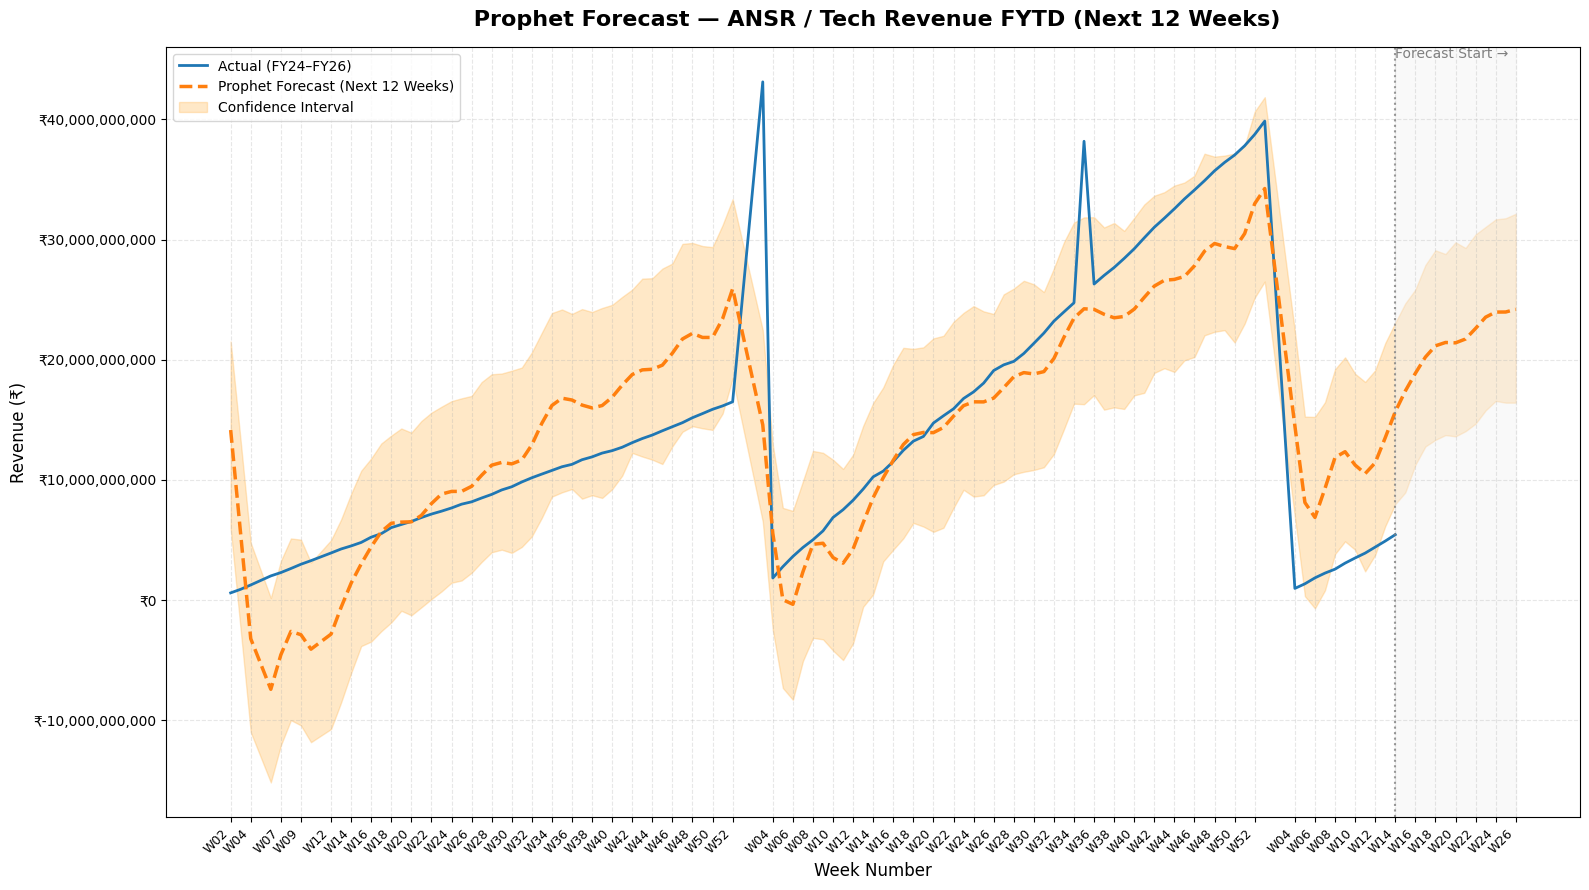

,ds,yhat,yhat_lower,yhat_upper
111,2026-04-06,1.739659e+10,8.953199e+09,2.469036e+10
112,2026-04-13,1.886617e+10,1.124988e+10,2.583402e+10
113,2026-04-20,2.021668e+10,1.277972e+10,2.787786e+10
114,2026-04-27,2.115381e+10,1.332889e+10,2.910265e+10
115,2026-05-04,2.143457e+10,1.372542e+10,2.879513e+10
116,2026-05-11,2.140331e+10,1.362309e+10,2.976773e+10
117,2026-05-18,2.172439e+10,1.405236e+10,2.929757e+10
118,2026-05-25,2.260456e+10,1.467821e+10,3.042131e+10
119,2026-06-01,2.354095e+10,1.578340e+10,3.105082e+10
120,2026-06-08,2.396463e+10,1.657081e+10,3.167533e+10


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === 1️⃣ Prepare data for Prophet ===
prophet_df = (
    weekly_data.reset_index()[["Date", "ANSR / Tech Revenue FYTD"]]
    .rename(columns={"Date": "ds", "ANSR / Tech Revenue FYTD": "y"})
    .dropna()
)

print("✅ Prophet data ready:", prophet_df.shape)
display(prophet_df.head())

# === 2️⃣ Train Prophet Model ===
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)
m.fit(prophet_df)

# === 3️⃣ Create future dataframe (12 weeks ahead) ===
future = m.make_future_dataframe(periods=12, freq='W-MON')
forecast = m.predict(future)

# === 4️⃣ Evaluate model performance ===
merged = prophet_df.merge(forecast[["ds", "yhat"]], on="ds", how="left")

y_true = merged["y"]
y_pred = merged["yhat"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-9))) * 100
r2 = r2_score(y_true, y_pred)

print("\n📊 Prophet Model Performance Metrics (Historical Fit)")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")

# === 5️⃣ Plot Actual + Forecast ===
plt.figure(figsize=(16,9))

# Plot actual values
plt.plot(prophet_df["ds"], prophet_df["y"], label="Actual (FY24–FY26)", color="#1f77b4", linewidth=2)

# Plot forecast (next 12 weeks)
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast (Next 12 Weeks)", 
         color="#ff7f0e", linestyle="--", linewidth=2.5)

# Confidence interval shading
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# === 6️⃣ Highlight forecast region ===
cutoff_date = prophet_df["ds"].max()
plt.axvline(cutoff_date, color="gray", linestyle=":", alpha=0.8)
plt.text(cutoff_date, plt.ylim()[1]*0.98, "Forecast Start →", color="gray", fontsize=10)
plt.axvspan(cutoff_date, forecast["ds"].max(), color="#f0f0f0", alpha=0.4)

# === 7️⃣ Format X-axis (Week numbers only, every 2 weeks) ===
tick_idx = forecast["ds"].iloc[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]

plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# === 8️⃣ Format Y-axis ===
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))

# === 9️⃣ Title, Labels, Styling ===
plt.title(" Prophet Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 🔟 Display forecasted values ===
display(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12))


Importing plotly failed. Interactive plots will not work.


✅ Prophet data ready: (111, 2)


,ds,y
0,2024-01-08,5.951470e+08
1,2024-01-15,8.963846e+08
2,2024-01-22,1.255661e+09
3,2024-02-05,2.007917e+09
4,2024-02-12,2.286815e+09


10:31:40 - cmdstanpy - INFO - Chain [1] start processing
10:31:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model fitted successfully!

📊 Prophet Model Performance Metrics (Historical Fit)
------------------------------------------------------------
   RMSE   : 5,867,389,361.87
   MAE    : 4,486,254,207.92
   MAPE   : 101.94%
   R²     : 0.7107
   Accuracy (≈ 100 - MAPE): -1.94%

📈 Classification Metrics (Trend Direction — Up vs Down)
------------------------------------------------------------
   Precision : 1.0000
   Recall    : 0.7570
   F1-Score  : 0.8617

🧮 Confusion Matrix:
          Pred ↓  Pred ↑
Actual ↓       4       0
Actual ↑      26      81


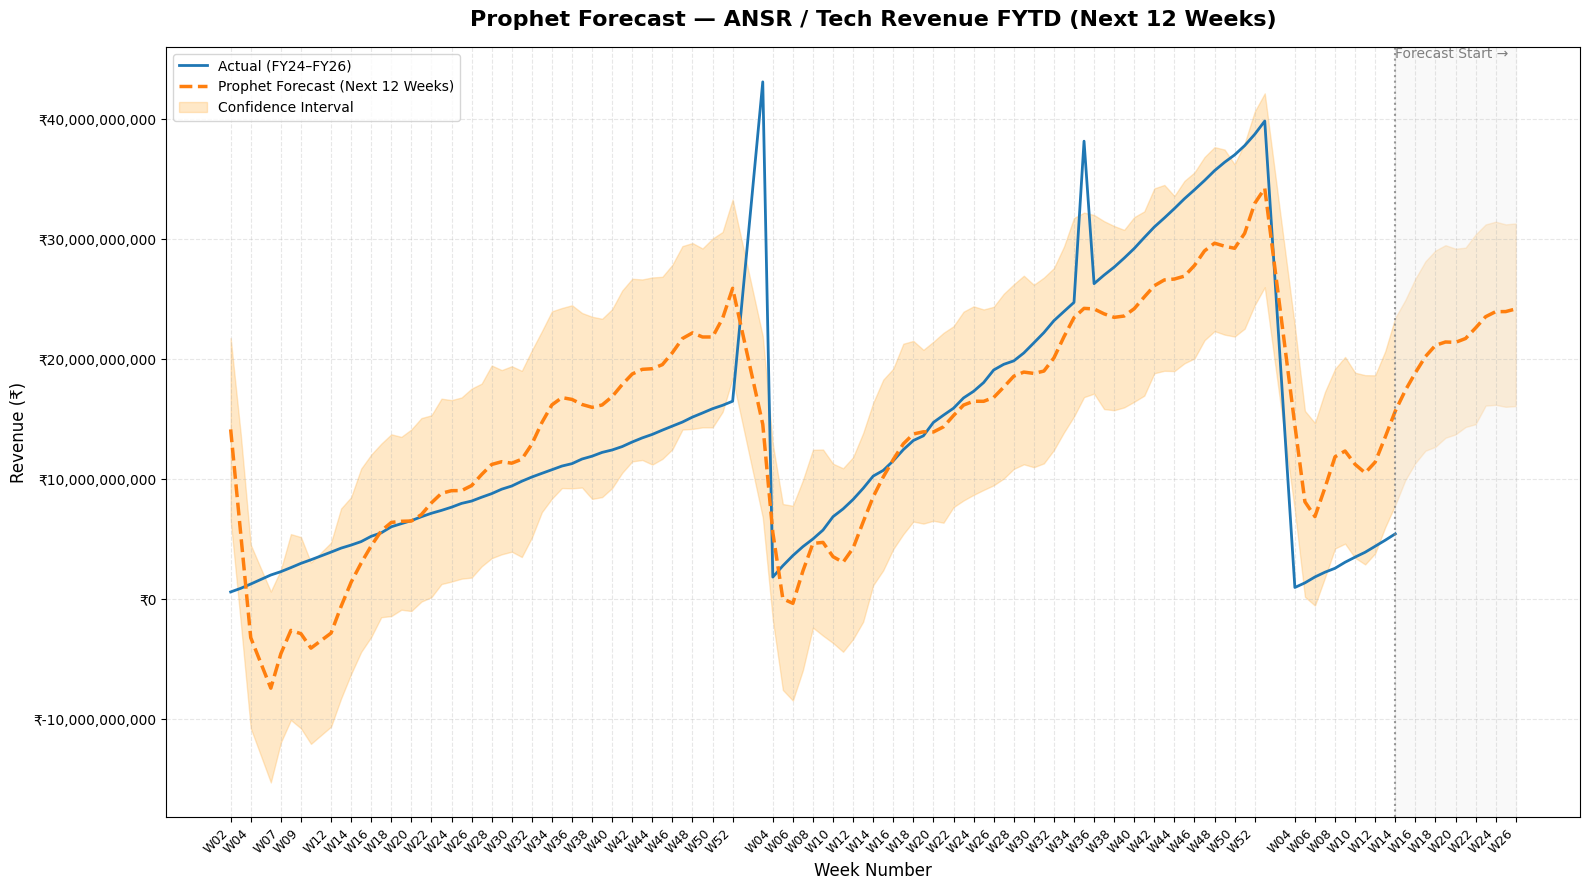

,ds,yhat,yhat_lower,yhat_upper
111,2026-04-06,1.739659e+10,9.917000e+09,2.492649e+10
112,2026-04-13,1.886617e+10,1.133948e+10,2.670552e+10
113,2026-04-20,2.021668e+10,1.236410e+10,2.815543e+10
114,2026-04-27,2.115381e+10,1.269838e+10,2.905578e+10
115,2026-05-04,2.143457e+10,1.344864e+10,2.950614e+10
116,2026-05-11,2.140331e+10,1.372931e+10,2.921198e+10
117,2026-05-18,2.172439e+10,1.434499e+10,2.929747e+10
118,2026-05-25,2.260456e+10,1.458225e+10,3.039502e+10
119,2026-06-01,2.354095e+10,1.612758e+10,3.123410e+10
120,2026-06-08,2.396463e+10,1.619701e+10,3.146341e+10


In [8]:
# =========================================================
# 🔮 PROPHET MODEL — Weekly Revenue Forecast (FYTD)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ PREPARE DATA FOR PROPHET =========================
prophet_df = (
    weekly_data.reset_index()[["Date", "ANSR / Tech Revenue FYTD"]]
    .rename(columns={"Date": "ds", "ANSR / Tech Revenue FYTD": "y"})
    .dropna()
)

print("✅ Prophet data ready:", prophet_df.shape)
display(prophet_df.head())

# === 2️⃣ TRAIN PROPHET MODEL ==============================
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

m.fit(prophet_df)
print("✅ Prophet model fitted successfully!")

# === 3️⃣ FORECAST NEXT 12 WEEKS ============================
future = m.make_future_dataframe(periods=12, freq='W-MON')
forecast = m.predict(future)

# === 4️⃣ MODEL EVALUATION (REGRESSION METRICS) =============
merged = prophet_df.merge(forecast[["ds", "yhat"]], on="ds", how="left")

y_true = merged["y"]
y_pred = merged["yhat"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-9))) * 100
r2 = r2_score(y_true, y_pred)
accuracy = 100 - mape

# === 5️⃣ CLASSIFICATION METRICS (UP/DOWN TREND) ============
# Convert to direction: 1 → increase, 0 → decrease
y_true_dir = (y_true.diff() > 0).astype(int).fillna(0)
y_pred_dir = (y_pred.diff() > 0).astype(int).fillna(0)

cm = confusion_matrix(y_true_dir, y_pred_dir)
precision = precision_score(y_true_dir, y_pred_dir, zero_division=0)
recall = recall_score(y_true_dir, y_pred_dir, zero_division=0)
f1 = f1_score(y_true_dir, y_pred_dir, zero_division=0)

# === 6️⃣ PRINT PERFORMANCE SUMMARY =========================
print("\n📊 Prophet Model Performance Metrics (Historical Fit)")
print("------------------------------------------------------------")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

print("\n📈 Classification Metrics (Trend Direction — Up vs Down)")
print("------------------------------------------------------------")
print(f"   Precision : {precision:.4f}")
print(f"   Recall    : {recall:.4f}")
print(f"   F1-Score  : {f1:.4f}")
print("\n🧮 Confusion Matrix:")
print(pd.DataFrame(cm, index=["Actual ↓", "Actual ↑"], columns=["Pred ↓", "Pred ↑"]))

# === 7️⃣ PLOT ACTUAL + FORECAST ============================
plt.figure(figsize=(16,9))

# Actual FYTD values
plt.plot(
    prophet_df["ds"],
    prophet_df["y"],
    label="Actual (FY24–FY26)",
    color="#1f77b4",
    linewidth=2
)

# Prophet forecast
plt.plot(
    forecast["ds"],
    forecast["yhat"],
    label="Prophet Forecast (Next 12 Weeks)",
    color="#ff7f0e",
    linestyle="--",
    linewidth=2.5
)

# Confidence Interval
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# Highlight forecast region
cutoff_date = prophet_df["ds"].max()
plt.axvline(cutoff_date, color="gray", linestyle=":", alpha=0.8)
plt.text(
    cutoff_date,
    plt.ylim()[1]*0.98,
    "Forecast Start →",
    color="gray",
    fontsize=10
)
plt.axvspan(cutoff_date, forecast["ds"].max(), color="#f0f0f0", alpha=0.4)

# === 8️⃣ FORMAT X-AXIS (Week numbers) =====================
tick_idx = forecast["ds"].iloc[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# === 9️⃣ FORMAT Y-AXIS + STYLING ==========================
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title("Prophet Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
          fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 🔟 DISPLAY FORECASTED VALUES =========================
display(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12))

# =========================================================


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === 1️⃣ Prepare Weekly Increment Data ===
# Compute week-over-week growth instead of FYTD cumulative
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)

prophet_df = (
    weekly_data.reset_index()[["Date", "Weekly_Increment"]]
    .rename(columns={"Date": "ds", "Weekly_Increment": "y"})
    .dropna()
)

print("✅ Prophet data ready:", prophet_df.shape)
display(prophet_df.head())

# === 2️⃣ Train Prophet Model ===
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)
m.fit(prophet_df)

# === 3️⃣ Create future dataframe (12 weeks ahead) ===
future = m.make_future_dataframe(periods=12, freq='W-MON')
forecast = m.predict(future)

# === 4️⃣ Evaluate model performance ===
merged = prophet_df.merge(forecast[["ds", "yhat"]], on="ds", how="left")

y_true = merged["y"]
y_pred = merged["yhat"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-9))) * 100
r2 = r2_score(y_true, y_pred)
accuracy = max(0, 100 - mape)

print("\n📊 Prophet Model Performance Metrics (Weekly Increment Forecast)")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

# === 5️⃣ Plot Actual + Forecast ===
plt.figure(figsize=(16,9))

# Plot actual weekly increments
plt.plot(prophet_df["ds"], prophet_df["y"], label="Actual Weekly Increment", color="#1f77b4", linewidth=2)

# Plot forecasted weekly increments
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast (Next 12 Weeks)", 
         color="#ff7f0e", linestyle="--", linewidth=2.5)

# Confidence interval shading
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# === 6️⃣ Highlight forecast region ===
cutoff_date = prophet_df["ds"].max()
plt.axvline(cutoff_date, color="gray", linestyle=":", alpha=0.8)
plt.text(cutoff_date, plt.ylim()[1]*0.98, "Forecast Start →", color="gray", fontsize=10)
plt.axvspan(cutoff_date, forecast["ds"].max(), color="#f0f0f0", alpha=0.4)

# === 7️⃣ Format X-axis (Week numbers only, every 2 weeks) ===
tick_idx = forecast["ds"].iloc[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# === 8️⃣ Format Y-axis ===
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))

# === 9️⃣ Title, Labels, Styling ===
plt.title("📈 Prophet Forecast — ANSR / Tech Revenue (Weekly Increment, Next 12 Weeks)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Weekly Increment (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 🔟 Display Forecast Values ===
display(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12))


In [61]:
# === 3️⃣ Evaluate on FY26 ===
ts_test = test_weekly["Weekly_Increment"]

# Forecast exactly same number of steps as test
steps_ahead = len(ts_test)
pred_test = fitted_model.forecast(steps=steps_ahead)

# Align both to same length
ts_test, pred_test = ts_test.iloc[:steps_ahead], pred_test[:steps_ahead]

# Avoid divide-by-zero in MAPE (use np.nanmean)
denominator = np.where(np.abs(ts_test) < 1e-6, np.nan, np.abs(ts_test))
mape = np.nanmean(np.abs((ts_test.values - pred_test.values) / denominator)) * 100
if np.isnan(mape):
    mape = 0

rmse = np.sqrt(mean_squared_error(ts_test, pred_test))
mae = mean_absolute_error(ts_test, pred_test)
r2 = r2_score(ts_test, pred_test)
accuracy = 100 - mape

print("✅ ARIMA Model Performance (Train on FY24–FY25 → Test on FY26)")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")


✅ ARIMA Model Performance (Train on FY24–FY25 → Test on FY26)
   RMSE   : 134,277,948.11
   MAE    : 118,099,075.89
   MAPE   : 30.39%
   R²     : 0.1096
   Accuracy (≈ 100 - MAPE): 69.61%


In [3]:
train_df=pd.read_pickle("FY24FY25.pkl")

✅ SARIMA Model Fitted Successfully!

📊 SARIMA Model Performance Metrics (Weekly Increment Series)
------------------------------------------------------------
   RMSE   : 10,783,414,139.19
   MAE    : 3,605,355,614.92
   MAPE   : 399.98%
   R²     : -0.7878
   Accuracy (≈ 100 - MAPE): -299.98%

📈 Classification Metrics (Trend Direction — Up vs Down)
------------------------------------------------------------
   Precision : 0.9500
   Recall    : 0.8636
   F1-Score  : 0.9048

🧮 Confusion Matrix:
          Pred ↓  Pred ↑
Actual ↓       0       1
Actual ↑       3      19


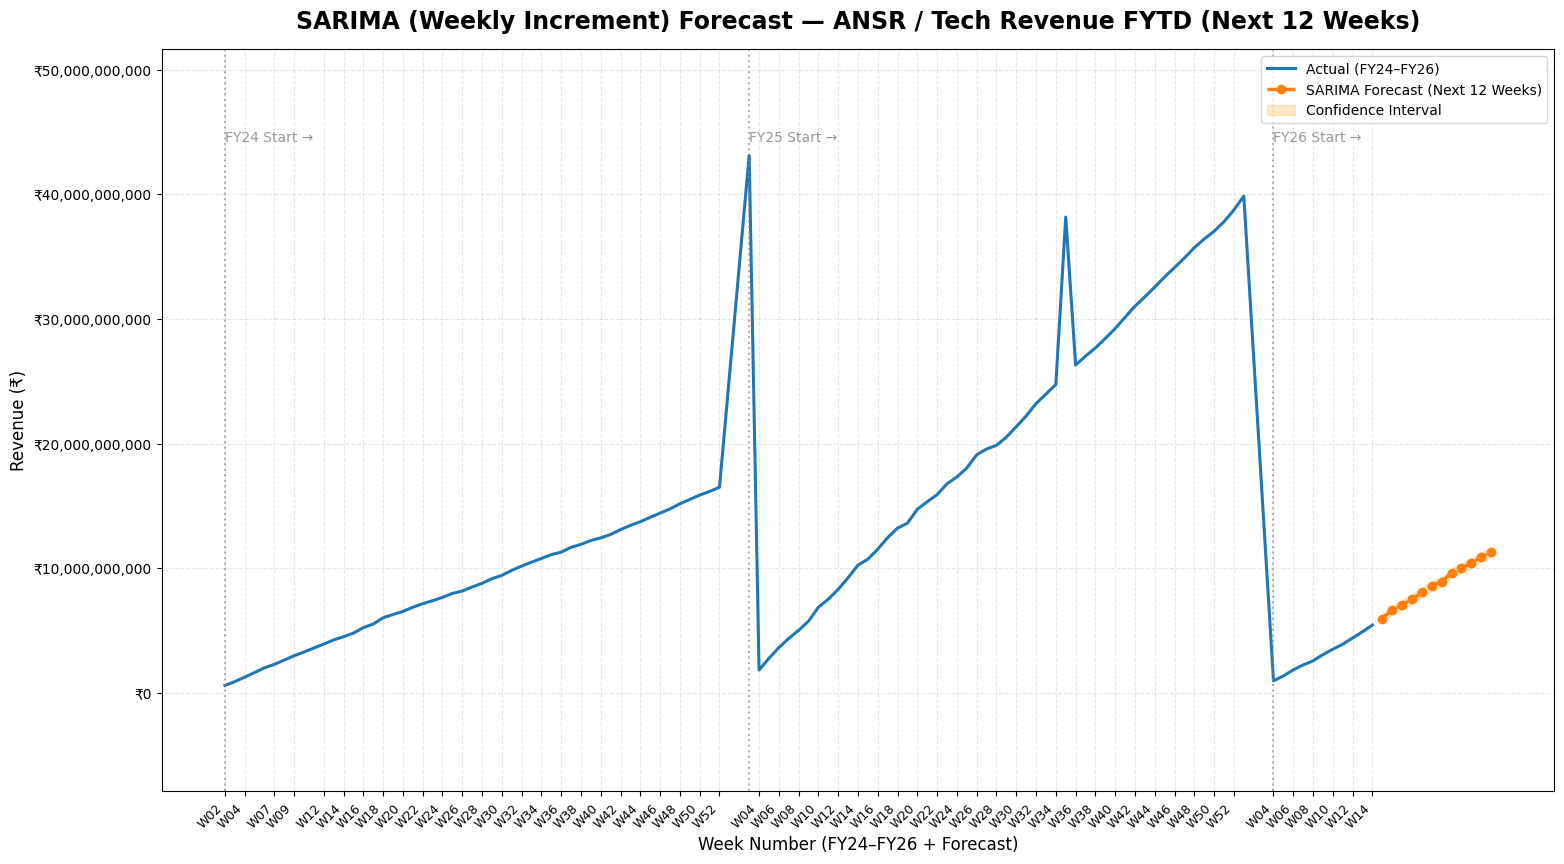

,Predicted Weekly Growth,Lower CI,Upper CI,Predicted FYTD
Date,,,,
2026-04-06,5.278512e+08,-1.784094e+10,1.889664e+10,5.966904e+09
2026-04-13,7.170429e+08,-1.850540e+10,1.993948e+10,6.683947e+09
2026-04-20,3.782861e+08,-2.056476e+10,2.132133e+10,7.062233e+09
2026-04-27,4.674750e+08,-2.188051e+10,2.281546e+10,7.529708e+09
2026-05-04,5.299549e+08,-2.316987e+10,2.422978e+10,8.059663e+09
2026-05-11,5.343044e+08,-2.443993e+10,2.550854e+10,8.593967e+09
2026-05-18,3.288300e+08,-2.585831e+10,2.651597e+10,8.922797e+09
2026-05-25,6.949497e+08,-2.665137e+10,2.804127e+10,9.617747e+09
2026-06-01,3.947180e+08,-2.806358e+10,2.885301e+10,1.001246e+10


In [7]:
# =========================================================
# 📈 SARIMA MODEL — Weekly Revenue Increment Forecasting
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ DATA PREPARATION =================================

# Combine training and test data
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Aggregate revenue by Year & Week
weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Convert "Year" → numeric and create proper date
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_data = weekly_data.sort_values("Date").set_index("Date")

# Create weekly increment column (difference week-to-week)
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)
ts_weekly = weekly_data["Weekly_Increment"]

# === 2️⃣ TRAIN SARIMA MODEL ===============================

sarima_model = SARIMAX(
    ts_weekly,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 52),  # annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fitted = sarima_model.fit(disp=False)
print("✅ SARIMA Model Fitted Successfully!")

# === 3️⃣ FORECAST NEXT 12 WEEKS ===========================

forecast_steps = 12
sarima_forecast = sarima_fitted.get_forecast(steps=forecast_steps)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Create weekly future dates
future_dates = pd.date_range(
    start=ts_weekly.index[-1] + pd.Timedelta(days=7),
    periods=forecast_steps,
    freq="W-MON"
)

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# Convert weekly growth → FYTD forecast
latest_fytd_value = weekly_data["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD"] = latest_fytd_value + forecast_df["Predicted Weekly Growth"].cumsum()

# === 4️⃣ MODEL EVALUATION (REGRESSION METRICS) ============

split_idx = int(len(ts_weekly) * 0.8)
y_train, y_test = ts_weekly.iloc[:split_idx], ts_weekly.iloc[split_idx:]
pred_test = sarima_fitted.predict(start=y_test.index[0], end=y_test.index[-1])

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2 = r2_score(y_test, pred_test)
accuracy = 100 - mape

# === 5️⃣ CLASSIFICATION METRICS (UP/DOWN TREND) ===========

# Convert numeric series into direction labels (+1 = increase, 0 = decrease)
y_test_dir = (y_test > 0).astype(int)
pred_test_dir = (pred_test > 0).astype(int)

cm = confusion_matrix(y_test_dir, pred_test_dir)
precision = precision_score(y_test_dir, pred_test_dir, zero_division=0)
recall = recall_score(y_test_dir, pred_test_dir, zero_division=0)
f1 = f1_score(y_test_dir, pred_test_dir, zero_division=0)

# === 6️⃣ PERFORMANCE SUMMARY ===============================

print("\n📊 SARIMA Model Performance Metrics (Weekly Increment Series)")
print("------------------------------------------------------------")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

print("\n📈 Classification Metrics (Trend Direction — Up vs Down)")
print("------------------------------------------------------------")
print(f"   Precision : {precision:.4f}")
print(f"   Recall    : {recall:.4f}")
print(f"   F1-Score  : {f1:.4f}")
print("\n🧮 Confusion Matrix:")
print(pd.DataFrame(cm, index=["Actual ↓", "Actual ↑"], columns=["Pred ↓", "Pred ↑"]))

# === 7️⃣ VISUALIZE FORECAST (FYTD LEVEL) ==================
plt.figure(figsize=(16,9))

# Actual FYTD
plt.plot(
    weekly_data.index,
    weekly_data["ANSR / Tech Revenue FYTD"],
    label="Actual (FY24–FY26)",
    color="#1f77b4",
    linewidth=2.2
)

# Forecasted FYTD
plt.plot(
    forecast_df.index,
    forecast_df["Predicted FYTD"],
    label="SARIMA Forecast (Next 12 Weeks)",
    color="#ff7f0e",
    linestyle="--",
    marker='o',
    linewidth=2.5
)

# Confidence Interval (±3σ)
plt.fill_between(
    forecast_df.index,
    forecast_df["Predicted FYTD"] - (forecast_df["Predicted Weekly Growth"].std()*3),
    forecast_df["Predicted FYTD"] + (forecast_df["Predicted Weekly Growth"].std()*3),
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# X-axis formatting
tick_idx = weekly_data.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# Fiscal Year markers
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start,
            weekly_data["ANSR / Tech Revenue FYTD"].max() * 1.02,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray", ha="left", va="bottom", alpha=0.8
        )

# Adjust Y-axis
y_min = min(weekly_data["ANSR / Tech Revenue FYTD"].min(), forecast_df["Predicted FYTD"].min())
y_max = max(weekly_data["ANSR / Tech Revenue FYTD"].max(), forecast_df["Predicted FYTD"].max())
y_buffer = (y_max - y_min) * 0.2
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Styling
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title(
    "SARIMA (Weekly Increment) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
    fontsize=17, weight="bold", pad=15
)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout(pad=2)
plt.show()

# === 8️⃣ DISPLAY FORECASTED VALUES ========================
display(forecast_df)

# =========================================================


In [11]:
# === 4️⃣ Create Continuous Timeline for Visualization ===

# Combine all weekly data for proper timeline
full_weekly = pd.concat([train_weekly, test_weekly])
full_weekly["Year_Num"] = full_weekly["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
full_weekly["Date"] = pd.to_datetime(
    full_weekly["Year_Num"].astype(str) + full_weekly["Week"].astype(str) + "1",
    format="%Y%W%w", errors="coerce"
)
full_weekly = full_weekly.sort_values("Date")

# === 5️⃣ Generate Forecast for Next 12 Weeks Beyond FY26 ===
forecast_steps = 12
future_forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_mean = future_forecast.predicted_mean
conf_int = future_forecast.conf_int()

# Create future dates
last_date = full_weekly.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=forecast_steps, freq="W-MON")

# Combine forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# Convert weekly growth back to FYTD-like forecast
latest_value = full_weekly["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD"] = latest_value + forecast_df["Predicted Weekly Growth"].cumsum()

# === 6️⃣ Combine Actual + Forecast for Plot ===
historical = full_weekly.copy()
combined_plot = pd.concat([
    historical[["ANSR / Tech Revenue FYTD"]],
    forecast_df[["Predicted FYTD"]]
], axis=0)

# === 7️⃣ Plot ===
plt.figure(figsize=(16,9))

# Actual line
plt.plot(
    historical.index, historical["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual (FY24–FY26)"
)

# Forecast line
plt.plot(
    forecast_df.index, forecast_df["Predicted FYTD"],
    color="#ff7f0e", linestyle="--", marker="o", linewidth=2.5, label="ARIMA Forecast (Next 12 Weeks)"
)

# Confidence interval shading
plt.fill_between(
    forecast_df.index,
    forecast_df["Predicted FYTD"] - (forecast_df["Predicted Weekly Growth"].std() * 2),
    forecast_df["Predicted FYTD"] + (forecast_df["Predicted Weekly Growth"].std() * 2),
    color="#ffb347", alpha=0.3, label="Confidence Interval"
)

# Highlight forecast region
cutoff_date = full_weekly.index.max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.7)
plt.axvspan(cutoff_date, forecast_df.index.max(), color="#f0f0f0", alpha=0.4)
plt.text(cutoff_date, plt.ylim()[1]*0.97, "Forecast Start →", color="gray", fontsize=10)

# Mark fiscal year starts
for fy in sorted(full_weekly["Year"].unique()):
    fy_start = full_weekly[full_weekly["Year"] == fy].index.min()
    plt.axvline(x=fy_start, color="gray", linestyle=":", alpha=0.5)
    plt.text(fy_start, plt.ylim()[1]*0.9, f"{fy} Start →", color="gray", fontsize=9)

# Format x-axis
tick_idx = combined_plot.index[::2]
tick_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=tick_labels, rotation=45, ha="right", fontsize=9)

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))

# Titles and labels
plt.title("📈 ARIMA Forecast — ANSR / Tech Revenue FYTD (FY24–FY26 + Next 12 Weeks)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


ValueError: 'Date' is both an index level and a column label, which is ambiguous.